In [29]:
pip install pandas openpyxl



Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install requests beautifulsoup4


Note: you may need to restart the kernel to use updated packages.


In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nba_api.stats.endpoints import leaguegamefinder, teamdashboardbygeneralsplits, playercareerstats
from nba_api.stats.endpoints import leagueleaders
from nba_api.stats.static import teams, players
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import re



In [34]:
playoff_results = pd.read_csv('data/playoff_results.csv') 
playoff_results.head()

,Yr,Lg,Series,Unnamed: 3,Unnamed: 4,Team,W,Unnamed: 7,Team.1,W.1,Unnamed: 10,Favorite,Underdog
0,2024,NBA,Eastern Conf First Round,Apr 21 - May 1 2024,NaN,Boston Celtics (1),4,NaN,Miami Heat (8),1,NaN,BOS (-10000),MIA (+2000)
1,2024,NBA,Eastern Conf First Round,Apr 20 - May 5 2024,NaN,Cleveland Cavaliers (4),4,NaN,Orlando Magic (5),3,NaN,CLE (-210),ORL (+180)
2,2024,NBA,Eastern Conf First Round,Apr 21 - May 2 2024,NaN,Indiana Pacers (6),4,NaN,Milwaukee Bucks (3),2,NaN,IND (-125),MIL (+105)
3,2024,NBA,Eastern Conf First Round,Apr 20 - May 2 2024,NaN,New York Knicks (2),4,NaN,Philadelphia 76ers (7),2,NaN,NYK (-140),PHI (+120)
4,2024,NBA,Western Conf First Round,Apr 21 - Apr 29 2024,NaN,Oklahoma City Thunder (1),4,NaN,New Orleans Pelicans (8),0,NaN,OKC (-700),NOP (+500)


In [94]:
def clean_and_extract_team_id(team_name):
    # Remove seed numbers and parentheses
    cleaned_name = re.sub(r'\s\(\d+\)', '', team_name)
    # Extract first three letters and convert to uppercase
    team_id = cleaned_name[:3].upper()
    return team_id

relabeled_dict = {
    "Team": "Team1",
    "Team.1": "Team2",
    "W": "Team1wins",
    "W.1": "Team2wins"
}

playoff_results = playoff_results.rename(columns=relabeled_dict)
playoff_results.head()  


,Yr,Lg,Series,Unnamed: 3,Unnamed: 4,Team1,Team1wins,Unnamed: 7,Team2,Team2wins,Unnamed: 10,Favorite,Underdog
0,2024,NBA,Eastern Conf First Round,Apr 21 - May 1 2024,NaN,Boston Celtics (1),4,NaN,Miami Heat (8),1,NaN,BOS (-10000),MIA (+2000)
1,2024,NBA,Eastern Conf First Round,Apr 20 - May 5 2024,NaN,Cleveland Cavaliers (4),4,NaN,Orlando Magic (5),3,NaN,CLE (-210),ORL (+180)
2,2024,NBA,Eastern Conf First Round,Apr 21 - May 2 2024,NaN,Indiana Pacers (6),4,NaN,Milwaukee Bucks (3),2,NaN,IND (-125),MIL (+105)
3,2024,NBA,Eastern Conf First Round,Apr 20 - May 2 2024,NaN,New York Knicks (2),4,NaN,Philadelphia 76ers (7),2,NaN,NYK (-140),PHI (+120)
4,2024,NBA,Western Conf First Round,Apr 21 - Apr 29 2024,NaN,Oklahoma City Thunder (1),4,NaN,New Orleans Pelicans (8),0,NaN,OKC (-700),NOP (+500)


In [100]:
playoff_results['Team1'] = playoff_results['Team1'].apply(clean_and_extract_team_id)
playoff_results['Team2'] = playoff_results['Team2'].apply(clean_and_extract_team_id) 
playoff_results.replace('CHA', 'CHO', inplace=True)
playoff_results.head()


,Yr,Lg,Series,Unnamed: 3,Unnamed: 4,Team1,Team1wins,Unnamed: 7,Team2,Team2wins,Unnamed: 10,Favorite,Underdog
0,2024,NBA,Eastern Conf First Round,Apr 21 - May 1 2024,NaN,BOS,4,NaN,MIA,1,NaN,BOS (-10000),MIA (+2000)
1,2024,NBA,Eastern Conf First Round,Apr 20 - May 5 2024,NaN,CLE,4,NaN,ORL,3,NaN,CLE (-210),ORL (+180)
2,2024,NBA,Eastern Conf First Round,Apr 21 - May 2 2024,NaN,IND,4,NaN,MIL,2,NaN,IND (-125),MIL (+105)
3,2024,NBA,Eastern Conf First Round,Apr 20 - May 2 2024,NaN,NEW,4,NaN,PHI,2,NaN,NYK (-140),PHI (+120)
4,2024,NBA,Western Conf First Round,Apr 21 - Apr 29 2024,NaN,OKL,4,NaN,NEW,0,NaN,OKC (-700),NOP (+500)


In [101]:
# Reshape the DataFrame so that both Team1 and Team2 are treated as teams with their respective wins
team1_wins = playoff_results[['Yr', 'Team1', 'Team1wins']].rename(columns={'Team1': 'Team', 'Team1wins': 'wins'})
team2_wins = playoff_results[['Yr', 'Team2', 'Team2wins']].rename(columns={'Team2': 'Team', 'Team2wins': 'wins'})

# Combine both team1 and team2 data into one DataFrame
combined_wins = pd.concat([team1_wins, team2_wins])

# Group by Year and Team, and sum the wins for each team
team_totals = combined_wins.groupby(['Yr', 'Team'], as_index=False)['wins'].sum()

# Display the resulting DataFrame
print(team_totals)

       Yr Team  wins
0    2016  ATL     4
1    2016  BOS     2
2    2016  CHO     3
3    2016  CLE    16
4    2016  DAL     1
..    ...  ...   ...
134  2024  NEW     7
135  2024  OKL     6
136  2024  ORL     3
137  2024  PHI     2
138  2024  PHO     0

[139 rows x 3 columns]


In [30]:
playoff_stats = pd.read_csv('data/playoffStats.csv')
playoff_stats.columns


playoff_stats['pts_per_36'] = (playoff_stats['pts_per_g'] / playoff_stats['mp_per_g']) * 36
playoff_stats['fg%'] = playoff_stats['fg_per_g']/playoff_stats['fga_per_g']


In [53]:
playoff_stats = playoff_stats[playoff_stats['season'] > 2015]
playoff_stats.head()
playoff_stats.columns

playoff_stats = playoff_stats.rename(columns={"team_id":"team"})

In [54]:
playoff_stats.head()

,season,player,pos,age,team,g,gs,mp_per_g,fg_per_g,fga_per_g,...,stl_pct,tov_pct,trb_pct,ts_pct,usg_pct,vorp,ws,ws_per_48,pts_per_36,fg%
0,2022,Omer Yurtseven,C,23,MIA,9,0.0,4.2,1.3,2.0,...,0.0,0.0,10.8,0.647,22.6,0.1,0.2,0.228,24.000000,0.650000
1,2022,Kessler Edwards,SF,21,BRK,2,0.0,3.5,0.0,0.0,...,7.3,100.0,0.0,NaN,6.6,0.0,0.0,-0.104,0.000000,NaN
2,2022,Draymond Green,PF,31,GSW,22,22.0,32.0,3.1,6.5,...,1.8,26.4,12.7,0.534,14.0,0.5,1.4,0.094,9.000000,0.476923
3,2022,Danny Green,SF,34,PHI,12,12.0,26.6,3.0,7.4,...,2.0,12.7,7.1,0.576,15.1,0.3,0.3,0.049,11.639098,0.405405
4,2022,Devonte' Graham,PG,26,NOP,6,0.0,10.0,1.0,3.0,...,0.9,15.7,8.9,0.558,18.3,0.0,0.1,0.049,14.400000,0.333333


In [110]:
# Merge the playoff_stats with the team_totals DataFrame
playoff_stats_with_wins = pd.merge(playoff_stats, team_totals, left_on=['season', 'team'], right_on=['Yr', 'Team'], how='left')

# Drop unnecessary columns (optional)
playoff_stats_with_wins.drop(columns=['Yr', 'Team'], inplace=True)

playoff_stats_with_wins = playoff_stats_with_wins.dropna()
playoff_stats_with_wins = playoff_stats_with_wins[['season', 'player', 'team', 'vorp', 'pts_per_36', 'fg%', 'wins']]

playoff_stats_with_wins.head()


,season,player,team,vorp,pts_per_36,fg%,wins
0,2022,Omer Yurtseven,MIA,0.1,24.000000,0.650000,11.0
3,2022,Danny Green,PHI,0.3,11.639098,0.405405,6.0
5,2022,Aaron Gordon,DEN,0.0,15.525000,0.425926,1.0
7,2022,Danilo Gallinari,ATL,0.0,16.392857,0.400000,1.0
8,2022,Bryn Forbes,DEN,0.0,9.473684,0.400000,1.0


In [113]:

# Step 1: Identify the top player for each team in each season
top_players = playoff_stats_with_wins.loc[playoff_stats_with_wins.groupby(['season', 'team'])['pts_per_36'].idxmax()]
top_players.head(10)



,season,player,team,vorp,pts_per_36,fg%,wins
1359,2016,Kris Humphries,ATL,0.2,23.914286,0.471429,4.0
1421,2016,Isaiah Thomas,BOS,0.3,23.738420,0.393939,2.0
1462,2016,Kemba Walker,CHO,0.4,22.026954,0.365297,3.0
1355,2016,Kyrie Irving,CLE,1.6,24.585366,0.477612,16.0
1524,2016,Dirk Nowitzki,DAL,0.2,21.600000,0.493976,1.0
1399,2016,Andre Drummond,DET,-0.1,18.439024,0.518519,0.0
1321,2016,James Harden,HOU,0.5,24.808290,0.410000,1.0
1449,2016,Joe Young,IND,0.0,33.120000,0.400000,3.0
1427,2016,Lance Stephenson,MEM,0.1,19.663866,0.527273,0.0
1451,2016,Dorell Wright,MIA,0.1,30.315789,0.500000,7.0


In [115]:
# List of metrics to compare
metrics = ['fg%', 'vorp', 'pts_per_36']

# Iterate over each player
for metric in metrics:
  correlation = top_players['wins'].corr(top_players[metric])
  print(f"Correlation between playoff wins and a team's best players' {metric} is {correlation:.2f}")


Correlation between playoff wins and a team's best players' fg% is -0.01
Correlation between playoff wins and a team's best players' vorp is 0.58
Correlation between playoff wins and a team's best players' pts_per_36 is -0.04


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


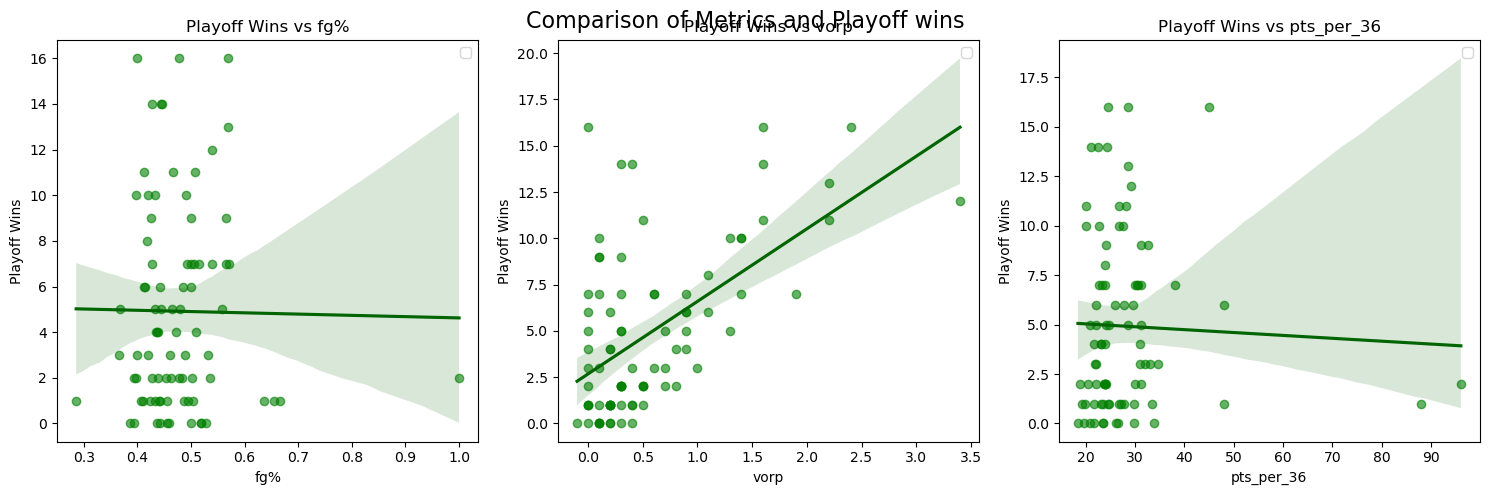

In [117]:
# 1x3 grid to display scatterplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Comparison of Metrics and Playoff wins', fontsize=16)

# Loop through each metric and plot a scatter plot with win percentage
for i, metric in enumerate(metrics):
    ax = axes[i]  # Directly access the axes from the 1D array

    sns.regplot(x=metric, y="wins", data=top_players, ax=ax, 
                scatter_kws={'color': 'green', 'alpha': 0.6}, line_kws={'color': 'darkgreen'})  

    # Plot titles/labels
    ax.set_title(f'Playoff Wins vs {metric}')
    ax.set_xlabel(metric)
    ax.set_ylabel('Playoff Wins')

    # Add legend (optional)
    ax.legend()

# Adjusting layout
plt.tight_layout()
plt.subplots_adjust(top=0.92)  # To prevent overlap with the title
plt.show()
